This file contains all the functions & results we need

In [41]:
# import packages
import pandas as pd
from numpy import nan
import math
import numpy as np

from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [105]:
def null_modifier(df):
    '''
    Changes the values which stand for of 'Not_reported', 'Unknown, 'None' to NA
    Param:
        df: the dataframe we take care of
    Returns:
        dataframe: a new dataframe with the replaced value
    '''
    
    # read the features
    features = pd.read_excel('Features_missing.xlsx')
    data = df.copy()
    
    # Check the corresponding code of "not_reported" for each feature
    Not_reported = features[features['Not_reported'].notnull()].reset_index(drop=True)
    Not_reported = Not_reported.loc[:,['Feature','Not_reported']]
    
    # Check the corresponding code of "Unknown" for each feature
    Unknown = features[features['Unknown'].notnull()].reset_index(drop=True)
    Unknown = Unknown.loc[:,['Feature','Unknown']]
    
    # Check the corresponding code of "None" for each feature
    none = features[features['None'].notnull()].reset_index(drop=True)
    none = none.loc[:,['Feature','None']]

    # Check the corresponding code of "Not_applicable" for each feature
    Not_Applicable = features[features['Not_Applicable'].notnull()].reset_index(drop=True)
    Not_Applicable = Not_Applicable.loc[:,['Feature','Not_Applicable']]
    
    # change all the not reported number in the dataframe to NA
    for x in range(Not_reported.shape[0]):
        feature = Not_reported.iloc[x,0]
        Not_reported_number = Not_reported.iloc[x,1]
        if feature in data.columns:
            data[feature] = data[feature].replace(Not_reported_number, np.nan)
    
    # change all the Unknown number to NA
    for x in range(Unknown.shape[0]):
        feature = Unknown.iloc[x,0]
        Unknown_number = Unknown.iloc[x,1]
        if feature in data.columns:

            data[feature] = data[feature]. replace(Unknown_number, np.nan)
    
    #### change all the None number to NA
    for x in range(none.shape[0]):
        feature = none.iloc[x,0]
        none_number = none.iloc[x,1]
        if feature in data.columns:
            data[feature] = data[feature]. replace(none_number, np.nan)

    #### change all the Not Applicable number to NA
    for x in range(Not_Applicable.shape[0]):
        feature = Not_Applicable.iloc[x,0]
        Not_Applicable_number = Not_Applicable.iloc[x,1]
        if feature in data.columns:
            data[feature] = data[feature]. replace(Not_Applicable_number, np.nan)
    
    return data

In [21]:
def drop_missing_columns(df):
    '''
    Drops the columns that have too many missing values
    threshold: 0.8
    
    Params: 
        df: the dataframe we need to process
    Returns:
        dataframe: a new dataframe without features containing too many missing values
    '''
    frac = len(df) * 0.8
    data = df.dropna(thresh=frac, axis = 1)
    data = data.drop('MDAREAS', axis = 1)
    return data

In [22]:
def items (df, c):
    '''
    function to get the item list of a column which does not include nan
    Params: 
        df: the dataframe the column is in
        c: the column we get the item list from
    Returns:
        list: a list contains unique items of column c
    '''

    vals = df[c].unique().tolist()
    # if it's numerical (numbers)
    if np.issubdtype(df[c].dtype, np.number) == True:
        vals = [x for x in vals if not math.isnan(x)]
        vals.sort()
        return vals
    else:
    # if it's str
        vals = [x for x in vals if x != np.nan]
        return vals

In [23]:
def inputnumerical ():
    '''
    ask users for the list of columns which don't need to be encoded. e.g. numerical columns
    Returns:
        list
    '''
    lst = [] 
    lst = [x for x in input("Enter columns that don't need to encode (eg: AAA BBB): ").split()] 
    return lst

In [24]:
def encoding(data):
    '''
    encodes the categorical columns to numbers in the numerical order
    e.g.: if the original column contains categories 1, 5, 9, 10,
        we encode it as 0, 1, 2, 3 correspondingly
    
    Param:
        df: the dataframe that we need to encode
    Returns:
        dataframe: the dataframe that we encoded
    '''

    # ask user which (numerical) columns should be skipped in this process
    df = data.copy()
    num_cols = inputnumerical()
    print('the number of column that dont need to encoded is', len(num_cols))
    
    # iterate columns
    for column in df:
        # check if the column is numerical
        if column in num_cols:
            continue
        # encoding
        else: 
            # get the length of the list of unique values
            unique = items(df, column)
            len_unique = len(unique)
            # make a new list contains 1,2,3,4,5...
            codes = list(range(0, len_unique))
            
            # using for loop to replace the value
            for i in range(0,len_unique):
                df[column].replace(to_replace = unique[i], value = codes[i], inplace = True)
    return df

I. personal level (dependent variable: INJSEV_IM)

In [25]:
p_data = pd.read_csv('person_level_full_data.csv',index_col=0)
p_data.head()

,CASENUM,REGION,PSU,PJ,PSU_VAR,URBANICITY,STRATUM,VE_TOTAL,VE_FORMS,PVH_INVL,...,PTRLR1VIN,PTRLR2VIN,PTRLR3VIN,MDAREAS,MFACTOR,MDRDSTRD,MDRMANAV,DRIMPAIR,MVIOLATN,MVISOBSC
0,201800381338,4.0,56.0,208.0,208.0,1.0,9.0,4.0,4.0,0.0,...,NaN,NaN,NaN,12,0.0,0.0,4.0,0.0,0.0,0.0
1,201800381338,4.0,56.0,208.0,208.0,1.0,9.0,4.0,4.0,0.0,...,NaN,NaN,NaN,"6,12",0.0,0.0,4.0,0.0,0.0,0.0
2,201800381338,4.0,56.0,208.0,208.0,1.0,9.0,4.0,4.0,0.0,...,NaN,NaN,NaN,"6,12",0.0,0.0,0.0,0.0,0.0,0.0
3,201800381338,4.0,56.0,208.0,208.0,1.0,9.0,4.0,4.0,0.0,...,NaN,NaN,NaN,6,0.0,0.0,0.0,0.0,0.0,0.0
4,201800381366,4.0,56.0,214.0,214.0,1.0,7.0,3.0,3.0,0.0,...,NaN,NaN,NaN,"1,2,10,11,12",0.0,0.0,98.0,0.0,0.0,0.0


In [26]:
p_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134420 entries, 0 to 134419
Columns: 226 entries, CASENUM to MVISOBSC
dtypes: float64(218), int64(1), object(7)
memory usage: 232.8+ MB


    1. pre-processing

In [63]:
# replace the 'Not_reported', 'Unknown, 'None' with NA 
p_data_dropped = null_modifier(p_data)
# drop the columns have too many missing values
p_data_dropped = drop_missing_columns(p_data_dropped)
# encode
p_data_dropped = encoding(p_data_dropped)


the number of column that dont need to encoded is 51


In [73]:
# list of repeated columns
repeated_col = ['DAY_WEEK', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL',
               'RELJCT2', 'LGT_COND', 'MAX_SEV', 'NUM_INJ','ALCOHOL','SEX',
               'INJ_SEV','EJECTION', 'SEAT_POS', 'AGE', 'HIT_RUN',
               'BODY_TYP', 'MOD_YEAR', 'IMPACT1', 'M_HARM', 'P_CRASH1', 'MAX_VSEV',
               'NUM_INJV', 'VEH_ALCH']

# drop the repeated columns
p_data_dropped = p_data_dropped.drop(repeated_col, axis=1)
# drop the observations that have missing values
p_data_dropped = p_data_dropped.dropna().reset_index(drop= True)
p_data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62933 entries, 0 to 62932
Columns: 103 entries, CASENUM to V_ALCH_IM
dtypes: float64(99), int64(1), object(3)
memory usage: 49.5+ MB


In [74]:
# check the correlation
for column in p_data_dropped.columns:
    if column not in list(p_data_dropped.select_dtypes(include=['object']).columns):
        corr = p_data_dropped['INJSEV_IM'].corr(p_data_dropped[column])
        if corr > 0.5:
            print(column, corr)

MAXSEV_IM 0.644332684881833
HOSPITAL 0.7084036786978373
INJSEV_IM 1.0
MXVSEV_IM 0.8949680694981887
NUMINJ_IM 0.6291539704411212


In [75]:
######################################################################
######################## modeling ####################################
######################################################################

In [82]:
# define X and y

# 'MXVSEV_IM' is dependent variable
y1 = p_data_dropped['INJSEV_IM']
# get object list
object_list = list(p_data_dropped.select_dtypes(include=['object']).columns)
# drop non-useful columns and the object columns
x1 = p_data_dropped.drop(['CASENUM','MXVSEV_IM','INJSEV_IM'],axis = 1)
x1 = x1.drop(object_list, axis=1)

    2. Decision tree

In [83]:

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, 
                                        test_size=0.3, random_state=42)
dt_basic = DecisionTreeClassifier()
dt_basic.fit(x1_train, y1_train)
y1_predict = dt_basic.predict(x1_test)

scores = cross_val_score(dt_basic, x1, y1, cv = 10)
print('Accuracy score of DT:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of DT with CV: ', scores.mean())

Accuracy score of DT: 0.9302436440677966
Accuracy score of DT with CV:  0.9161486746841092


Feature importance by decision tree


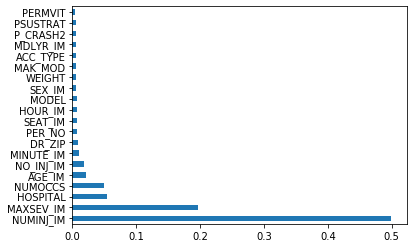

In [86]:
# feature importance
print('Feature importance by decision tree')
feat_importances = pd.Series(dt_basic.feature_importances_, index=x1.columns)
feat_importances.nlargest(20).plot(kind='barh')
pyplot.show()

In [87]:
print(confusion_matrix(y1_test, y1_predict))

[[13203   242    89     3     3     0     1]
 [  217  2222   154    56    11     1     0]
 [   48   173  1200    86     6     0     0]
 [    2    58   113   849    13     0     0]
 [    2    13    16     6    88     0     0]
 [    0     4     0     0     0     1     0]
 [    0     0     0     0     0     0     0]]


    3. Random Forest

In [91]:
rf_basic = RandomForestClassifier()
rf_basic.fit(x1_train, y1_train)
y1_predict = rf_basic.predict(x1_test)

scores = cross_val_score(rf_basic, x1, y1, cv = 10)
print('RF:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of RF with CV: ', scores.mean())

RF: 0.9365995762711864
Accuracy score of RF with CV:  0.9306880539864757


Feature importance by decision tree


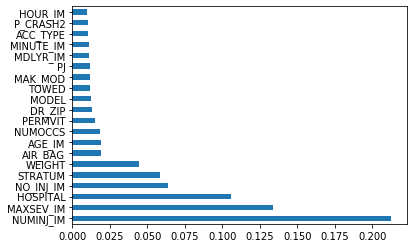

In [92]:
# feature importance
print('Feature importance by decision tree')
feat_importances = pd.Series(rf_basic.feature_importances_, index=x1.columns)
feat_importances.nlargest(20).plot(kind='barh')
pyplot.show()

In [93]:
print(confusion_matrix(y1_test, y1_predict))

[[13274   210    55     1     1     0]
 [  252  2169   165    69     6     0]
 [   67    91  1227   125     3     0]
 [    3    22    39   965     6     0]
 [    6     3    19    50    47     0]
 [    0     3     1     0     0     1]]


    4. KNN

In [96]:
knn_basic = KNeighborsClassifier()
knn_basic.fit(x1_train, y1_train)
y1_predict = knn_basic.predict(x1_test)

scores = cross_val_score(knn_basic, x1, y1, cv = 10)
print('KNN:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of KNN with CV: ', scores.mean())

KNN: 0.7191737288135593
Accuracy score of KNN with CV:  0.6804536855073888


In [95]:
print(confusion_matrix(y1_test, y1_predict))

[[12457   735   226   117     6     0]
 [ 1849   659   114    36     3     0]
 [  955   234   258    62     2     2]
 [  555   147   129   202     2     0]
 [   80    19    19     6     1     0]
 [    2     1     1     0     0     1]]


    5. SVC

In [99]:
svc_basic = svm.SVC()
svc_basic.fit(x1_train, y1_train)
y1_predict = svc_basic.predict(x1_test)

scores = cross_val_score(svc_basic, x1, y1, cv = 10)
print('SVC:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of SVC with CV: ', scores.mean())

SVC: 0.7172139830508475
Accuracy score of SVC with CV:  0.7155069707637385


In [100]:
print(confusion_matrix(y1_test, y1_predict))

[[13541     0     0     0     0     0]
 [ 2661     0     0     0     0     0]
 [ 1513     0     0     0     0     0]
 [ 1035     0     0     0     0     0]
 [  125     0     0     0     0     0]
 [    5     0     0     0     0     0]]


II. vehicle level (dep variable: MXVSEV_IM)

In [109]:
v_data = pd.read_csv('vehicle_level_full_data.csv',index_col=0)
v_data.head()

,CASENUM,REGION,PSU,PJ,PSU_VAR,URBANICITY,STRATUM,VE_TOTAL,VE_FORMS,PVH_INVL,...,PTRLR1VIN,PTRLR2VIN,PTRLR3VIN,MDAREAS,MFACTOR,MDRDSTRD,MDRMANAV,DRIMPAIR,MVIOLATN,MVISOBSC
0,201800381338,4,56,208,208,1,9,4,4,0,...,NaN,NaN,NaN,12,0,0,4,0,0,0
1,201800381338,4,56,208,208,1,9,4,4,0,...,NaN,NaN,NaN,"6,12",0,0,4,0,0,0
2,201800381338,4,56,208,208,1,9,4,4,0,...,NaN,NaN,NaN,"6,12",0,0,0,0,0,0
3,201800381338,4,56,208,208,1,9,4,4,0,...,NaN,NaN,NaN,6,0,0,0,0,0,0
4,201800381366,4,56,214,214,1,7,3,3,0,...,NaN,NaN,NaN,"1,2,10,11,12",0,0,98,0,0,0


In [110]:
# replace the 'Not_reported', 'Unknown, 'None' with NA 
v_data_dropped = null_modifier(v_data)
# drop the columns have too many missing values
v_data_dropped = drop_missing_columns(v_data_dropped)
# encode

# CASENUM PJ STARATUM PSUSTRAT VEH_NO PER_NO STR_VEH MAKE MAK_MOD MODEL DR_ZIP VIN MCARR_I2 MCARR_ID TRLR1VIN TRLR2VIN TRLR3VIN PMODEL PMAK_MOD PVIN PMCARR_I1 PMCARR_I2 PMCARR_ID PHAZ_ID PTRLR1VIN PTRLR2VIN PTRLR3VIN HAZ_ID VE_TOTAL VE_FORMS PVH_INVL PERMVIT PERNOTMVIT NUM_INJ NUMINJ_IM WEIGHT AGE AGE_IM PBAGE NUMOCCS TRAV_SP MONTH YEAR DAY_WEEK HOUR MINUTE MOD_YEAR PMODYEAR PMONTH PHOUR PMINUTE
v_data_dropped = encoding(v_data_dropped)

the number of column that dont need to encoded is 51


In [111]:
# list of repeated columns
repeated_col = ['DAY_WEEK', 'HOUR', 'MINUTE', 'HARM_EV', 'MAN_COLL',
               'RELJCT2', 'LGT_COND', 'MAX_SEV', 'NUM_INJ','ALCOHOL',
               'HIT_RUN',
               'BODY_TYP', 'MOD_YEAR', 'IMPACT1', 'M_HARM', 'P_CRASH1', 'MAX_VSEV',
               'NUM_INJV', 'VEH_ALCH']

# drop the repeated columns
v_data_dropped = v_data_dropped.drop(repeated_col, axis=1)
# drop the observations that have missing values
v_data_dropped = v_data_dropped.dropna().reset_index(drop= True)
v_data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45491 entries, 0 to 45490
Data columns (total 88 columns):
CASENUM       45491 non-null int64
REGION        45491 non-null int64
PSU           45491 non-null int64
PJ            45491 non-null int64
PSU_VAR       45491 non-null int64
URBANICITY    45491 non-null int64
STRATUM       45491 non-null int64
VE_TOTAL      45491 non-null int64
VE_FORMS      45491 non-null int64
PVH_INVL      45491 non-null int64
PEDS          45491 non-null int64
PERMVIT       45491 non-null int64
PERNOTMVIT    45491 non-null int64
MONTH         45491 non-null int64
YEAR          45491 non-null int64
TYP_INT       45491 non-null float64
REL_ROAD      45491 non-null float64
WEATHER1      45491 non-null float64
WEATHER2      45491 non-null float64
WEATHER       45491 non-null float64
SCH_BUS       45491 non-null int64
INT_HWY       45491 non-null float64
WKDY_IM       45491 non-null int64
HOUR_IM       45491 non-null int64
MINUTE_IM     45491 non-null int64
EVEN

In [113]:
########
## 'MXVSEV_IM' is dependent variable

# check the correlation
for column in v_data_dropped.columns:
    if column not in list(v_data_dropped.select_dtypes(include=['object']).columns):
        corr = v_data_dropped['MXVSEV_IM'].corr(v_data_dropped[column])
        if corr > 0.5:
            print(column, corr)

MAXSEV_IM 0.7077395120195795
NO_INJ_IM 0.5383095657787961
MXVSEV_IM 1.0
NUMINJ_IM 0.7643311849775678


In [120]:
########
## 'MXVSEV_IM' is dependent variable

y1 = v_data_dropped['MXVSEV_IM']
# get object list
object_list = list(v_data_dropped.select_dtypes(include=['object']).columns)

x1 = v_data_dropped.drop(['CASENUM','MXVSEV_IM','MAXSEV_IM','NUMINJ_IM'],axis = 1)
x1 = x1.drop(object_list, axis=1)

    2. Decision tree

In [133]:

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, 
                                        test_size=0.3, random_state=42)
dt_basic = DecisionTreeClassifier()
dt_basic.fit(x1_train, y1_train)
y1_predict = dt_basic.predict(x1_test)

scores = cross_val_score(dt_basic, x1, y1, cv = 10)
print('Accuracy score of DT:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of DT with CV: ', scores.mean())

Accuracy score of DT: 0.8094226260257913
Accuracy score of DT with CV:  0.7826385753178455


Feature importance by decision tree


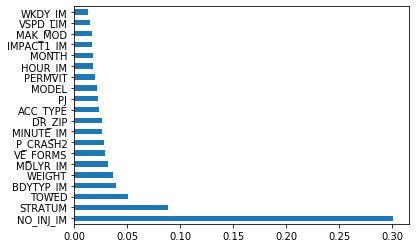

In [134]:
# feature importance
print('Feature importance by decision tree')
feat_importances = pd.Series(dt_basic.feature_importances_, index=x1.columns)
feat_importances.nlargest(20).plot(kind='barh')
pyplot.show()

In [135]:
print(confusion_matrix(y1_test, y1_predict))

[[8613  331  146   89    4    1]
 [ 356 1171  478   66    8    0]
 [ 161  479  582   75   15    0]
 [  99   60  110  640   49    0]
 [   3   14   17   38   41    0]
 [   2    0    0    0    0    0]]


    3. Random Forest

In [136]:
rf_basic = RandomForestClassifier()
rf_basic.fit(x1_train, y1_train)
y1_predict = rf_basic.predict(x1_test)

scores = cross_val_score(rf_basic, x1, y1, cv = 10)
print('RF:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of RF with CV: ', scores.mean())

RF: 0.8446658851113716
Accuracy score of RF with CV:  0.8240091941472464


Feature importance by decision tree


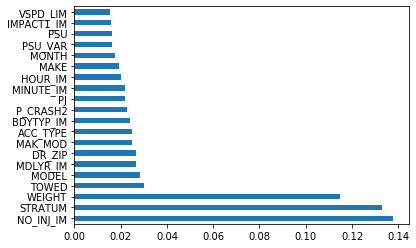

In [137]:
# feature importance
print('Feature importance by decision tree')
feat_importances = pd.Series(rf_basic.feature_importances_, index=x1.columns)
feat_importances.nlargest(20).plot(kind='barh')
pyplot.show()

In [138]:
print(confusion_matrix(y1_test, y1_predict))

[[8850  254   14   66    0    0]
 [ 399 1427  169   83    1    0]
 [ 172  589  448  103    0    0]
 [  71   12   80  794    1    0]
 [   3    3   17   81    9    0]
 [   2    0    0    0    0    0]]


    4. KNN


In [139]:
knn_basic = KNeighborsClassifier()
knn_basic.fit(x1_train, y1_train)
y1_predict = knn_basic.predict(x1_test)

scores = cross_val_score(knn_basic, x1, y1, cv = 10)
print('KNN:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of KNN with CV: ', scores.mean())

KNN: 0.6762162954279015
Accuracy score of KNN with CV:  0.6626805311637143


In [140]:
print(confusion_matrix(y1_test, y1_predict))

[[8425  488  173   95    3    0]
 [1494  414  120   50    1    0]
 [ 855  208  194   53    2    0]
 [ 534  145   81  194    4    0]
 [  53   28   15   15    2    0]
 [   1    0    0    1    0    0]]


    5. SVC

In [ ]:
svc_basic = SVC()
svc_basic.fit(x1_train, y1_train)
y1_predict = svc_basic.predict(x1_test)

scores = cross_val_score(svc_basic, x1, y1, cv = 10)
print('SVC:',accuracy_score(y1_test, y1_predict))
print('Accuracy score of SVC with CV: ', scores.mean())

In [ ]:
print(confusion_matrix(y1_test, y1_predict))